<a href="https://colab.research.google.com/github/kosirobwada/DeepLearningFromZero2/blob/main/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第4章 word2vecの改良

# Embedding層の実装

・扱うコーパスが増加すると、単語のone-hot表現の次元数が増える。

・これにより、巨大なベクトルと重み行列の積を取らなければいけなくなる。

・これを解決するために、Embedding層の追加。

・行列から行を抜き出す処理を行う。

In [2]:
import numpy as np
W = np.arange(21).reshape(7,3)
print(W)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]


In [3]:
idx = np.array([1,0,3,0])
print(W[idx])

[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


In [6]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dw, = self.grads
    dw[...] = 0

    for i, word_id in enumerate(self.idx):
      dw[word_id] += dout[i]
    return None

# Negative Sampling

・中間層以降の行列の積とSoftMax層の計算がボトルネック。

・これを解決する策としてNegative Sampling（負例サンプリング）

・SoftMaxの代わりに、Negative Samplingを用いることで、語彙数がどれだけ多くなったとしても、計算量を抑えることができる。

In [7]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None

  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W = h, axis=1)
    self.cache = (h,target_W)
    return out

  def backward(self, dout):
    h, target_W = self.cache
    dout = dout.reshape(dout.shape[0], 1)

    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

# 確率分布

・Negative Samplingする際に、負例をどのようにサンプリングするか？

・コーパスの中で、抽出されやすい語はサンプリングされやすくし、抽出されにくい語はサンプリングされにくくする。

・コーパスの中で単語の使用頻度に応じてサンプリングするには、コーパスから各単語の出現頻度を求め、確率分布で表す。



In [8]:
np.random.choice(10)

9

In [10]:
np.random.choice(10)

5

In [16]:
words = ['you','say','goodbye','I','say','hello']
print(np.random.choice(words))
print(np.random.choice(words))
print(np.random.choice(words, size=5))
print(np.random.choice(words, size=5, replace=False))

p = [0.5,0.1,0.05,0.2,0.05,0.1]
print(np.random.choice(words, p=p))

say
I
['you' 'say' 'you' 'I' 'say']
['goodbye' 'you' 'say' 'hello' 'say']
you


元の確率分布を0.75乗する。

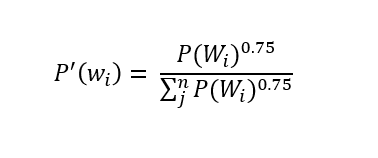

In [15]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
print(new_p)

new_p /= np.sum(new_p)
print(new_p)

[0.76528558 0.39518322 0.03162278]
[0.64196878 0.33150408 0.02652714]


In [22]:
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()

        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)

        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        # this code doesn't apply CuPy because I don't have Nvidia GPU
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(
                self.vocab_size,
                size=self.sample_size,
                replace=False,
                p=p)

        return negative_sample


In [23]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 0]
 [4 1]
 [2 3]]


In [27]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # if training data is one-hot-vector
    # then convert to teaching label's index
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [28]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None # sigmoid output
        self.t = None # teaching data

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

In [29]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []

        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # positive example forward
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # negative example forward
        negative_label = np.zeros(batch_size, dtype=np.int32)

        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0

        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh